# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

[Te proporcionamos algunos comentarios para orientarte mientras completas este proyecto. Pero debes asegurarte de eliminar todos los comentarios entre corchetes antes de entregar tu proyecto.]

[Antes de sumergirte en el análisis de datos, explica por tu propia cuenta el propósito del proyecto y las acciones que planeas realizar.]

[Ten en cuenta que estudiar, modificar y analizar datos es un proceso iterativo. Es normal volver a los pasos anteriores y corregirlos/ampliarlos para permitir nuevos pasos.]

## Inicialización

In [1]:
# Cargar todas las librerías
from scipy import stats as st
import numpy as np
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene

## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
df_calls = pd.read_csv('/datasets/megaline_calls.csv')
df_internet = pd.read_csv('/datasets/megaline_internet.csv')
df_messages = pd.read_csv('/datasets/megaline_messages.csv')
df_plans = pd.read_csv('/datasets/megaline_plans.csv')
df_users = pd.read_csv('/datasets/megaline_users.csv')

## Preparar los datos

[Los datos para este proyecto se dividen en varias tablas. Explora cada una para tener una comprensión inicial de los datos. Si es necesario, haz las correcciones requeridas en cada tabla.]

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas

df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas

df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Corregir datos

- Se puede observar que el tipo de dato que corresponde a cada columna es el esperado; esto es, la cantidad de mensajes de texto, la cantidad de datos y los minutos de cada plan son tipo int, los precios de los planes, los mensajes de texto, los minutos y los GB son valores numéricos y el nombre de cada plan corresponde a datos tipo object.

- Se modificará el nombre de la columna 'plan_name' a 'plan'.

- Se convertitrán las unidades de MB a GB, así como también se cambiará el nombre de esta columna a gb_per_month_included ya que el costo de éste servicio se calcula por la cantidad total de GB del mes.

- Debido a lo pequeño que es el dataframe, no es necesario realizar conteo de filas duplicadas ni de valores ausentes que por simple inspección visual se puede observar esto.

In [5]:
df_plans.rename(columns = {'plan_name': 'plan'}, inplace = True)
df_plans


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Enriquecer los datos

In [6]:
# Se convierten las unidades de MB a GB:
df_plans['mb_per_month_included'] = df_plans['mb_per_month_included'] / 1024

# Se cambia el tipo de valor de la columna a int:
df_plans['mb_per_month_included'] = df_plans['mb_per_month_included'].astype(int)

# Se cambia el nombre de la columna de 'mb_per_month_included' a 'gb_per_month_included'
df_plans.rename(columns = {'mb_per_month_included': 'gb_per_month_included'}, inplace = True)
df_plans

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


## Usuarios/as

In [7]:
# Imprime la información general/resumida sobre el DataFrame de usuarios

df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
# Imprime una muestra de datos para usuarios

df_users.head(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN


- Es normal y esperado que se encuentren muchos valores ausentes en la columna 'churn_date' ya que solo aparecerá una fecha en aquellos clientes que se hayan retirado o clientes de la empresa o que hayan cambiado de plan.

### Corregir los datos

In [9]:
# Se cuenta la cantidad de datos ausentes:
print('La cantidad de valores ausentes por columna es:\n', df_users.isna().sum())

# Se cuenta la cantidad de filas duplicadas:
print('\n La cantidad de filas duplicadas es:', df_users.duplicated().sum(), '\n')

# Se corrige el tipo de datos de las columnas de fecha ya que aparecen como tipo object y se cambiarán a datetime
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'])
df_users.info()

La cantidad de valores ausentes por columna es:
 user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

 La cantidad de filas duplicadas es: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Enriquecer los datos

- Adicional al cambio de tipo de dato de las columnas de fecha, no se considera necesario realizar ninguna otra modificación al dataframe de usuarios.

- No se encuentran datos ausentes en otras columnas diferentes a la de fecha de retiro.

- No hay filas totalmente duplicadas.

## Llamadas

In [10]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas

df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [11]:
# Imprime una muestra de datos para las llamadas
print('La cantidad total de datos ausentes por columna es:\n',df_calls.isna().sum(),'\n')
print('La cantidad total de filas duplicadas es:\n',df_calls.duplicated().sum(),'\n')
df_calls.head(10)

La cantidad total de datos ausentes por columna es:
 id           0
user_id      0
call_date    0
duration     0
dtype: int64 

La cantidad total de filas duplicadas es:
 0 



,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
5,1000_388,1000,2018-12-31,2.20
6,1000_510,1000,2018-12-27,5.75
7,1000_521,1000,2018-12-28,14.18
8,1000_530,1000,2018-12-28,5.77
9,1000_544,1000,2018-12-26,4.40


### Corregir los datos

- No se observan datos ausentes.

- No se hallan filas duplicadas.

- Se corrige el tipo de dato de la columna 'call_date' el cual es del tipo object y debe cambiarse a datetime.

- La duración de cada llamada se redondea hacia el entero superior.

In [12]:
# Se cuentan la cantidad de dilas duplicadas:
print('La cantidad total de datos ausentes por columna es:\n',df_calls.isna().sum())
print('La cantidad de filas duplicadas es: ', df_calls.duplicated().sum(), '\n')

# Se redondea hacia arriba la duración de las llamadas ya que la fracción de minuto se cuenta como una unidad:
df_calls['duration'] = np.ceil(df_calls['duration'])

# Se convierte el tipo de dato de la columna 'duration' de float a int:
df_calls['duration'] = df_calls['duration'].astype(int)

# Se cambia el tipo de dato de la columna 'call_date'
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_calls.info()

La cantidad total de datos ausentes por columna es:
 id           0
user_id      0
call_date    0
duration     0
dtype: int64
La cantidad de filas duplicadas es:  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.2+ MB


- No hay filas totalemnte duplicadas.

- No hay datos ausentes en ninguna columna.

- Se ha cambiado el tipo de dato de la columna call_date de object a datetime.

### Enriquecer los datos

In [13]:
# Se puede agregar la columna de mes ya que esta nos permite agrupar valores por mes.
df_calls['month'] = df_calls['call_date'].dt.month
df_calls.head(10)

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,5,12
5,1000_388,1000,2018-12-31,3,12
6,1000_510,1000,2018-12-27,6,12
7,1000_521,1000,2018-12-28,15,12
8,1000_530,1000,2018-12-28,6,12
9,1000_544,1000,2018-12-26,5,12


- Se adiciona la columna de mes para poder realizar agrupaciones por esta columna.

## Mensajes

In [14]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes

df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [15]:
# Imprime una muestra de datos para los mensajes

df_messages.head(10)

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
5,1000_346,1000,2018-12-29
6,1000_386,1000,2018-12-30
7,1000_413,1000,2018-12-31
8,1000_502,1000,2018-12-27
9,1000_525,1000,2018-12-28


- No se observan valores ausentes en ninguna columna.

- El tipo de dato de la columna 'message_date' debe cambiarse de object a datetime.

### Corregir los datos

In [16]:
# Se cuentan los datos ausentes de cada columna y las cantidad de filas totalmente duplicadas:
print('La cantidad de datos ausentes por columna es:\n',df_messages.isna().sum())
print('La cantidad filas duplicadas es: ', df_messages.duplicated().sum(), '\n')

# Se cambia el tipo de dato de la columna 'message_date' de object a datetime.
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_messages.info()

La cantidad de datos ausentes por columna es:
 id              0
user_id         0
message_date    0
dtype: int64
La cantidad filas duplicadas es:  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


- No se encuentran datos ausentes en ninguna columna.

- No se enceuntran filas totalmente duplicadas.

### Enriquecer los datos

In [17]:
# Para poder agrupar los datos por mes, se agrega la columna de mes:
df_messages['month'] = df_messages['message_date'].dt.month
df_messages.head(10)

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12
5,1000_346,1000,2018-12-29,12
6,1000_386,1000,2018-12-30,12
7,1000_413,1000,2018-12-31,12
8,1000_502,1000,2018-12-27,12
9,1000_525,1000,2018-12-28,12


## Internet

In [18]:
# Imprime la información general/resumida sobre el DataFrame de internet

df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [19]:
# Imprime una muestra de datos para el tráfico de internet

df_internet.head(10)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
5,1001_0,1001,2018-08-24,284.68
6,1001_3,1001,2018-12-09,656.04
7,1001_4,1001,2018-11-04,16.97
8,1001_10,1001,2018-11-27,135.18
9,1001_15,1001,2018-12-13,761.92


- Se puede observar que no existen valores ausentes en ninguna columna.

- Se puede observar que el tipo de dato de la columna 'session_date' es del tipo object por lo que se debe cambiar a datetime.

### Corregir los datos

In [20]:
# Se cuenta la cantidad valores ausentes en cada columna y la cantidad de filas totalmente duplicadas:
print('La cantidad de valores ausentes por cada columna es:\n', df_internet.isna().sum())
print('La cantidad de filas duplicadas es: ', df_internet.duplicated().sum(), '\n')

df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])
df_internet.info()

La cantidad de valores ausentes por cada columna es:
 id              0
user_id         0
session_date    0
mb_used         0
dtype: int64
La cantidad de filas duplicadas es:  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


- No hay columnas con valores ausentes.

- No hay filas totalmente duplicadas.

### Enriquecer los datos

In [21]:
df_internet['month'] = df_internet['session_date'].dt.month
df_internet.head(10)

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12
5,1001_0,1001,2018-08-24,284.68,8
6,1001_3,1001,2018-12-09,656.04,12
7,1001_4,1001,2018-11-04,16.97,11
8,1001_10,1001,2018-11-27,135.18,11
9,1001_15,1001,2018-12-13,761.92,12


## Estudiar las condiciones de las tarifas

In [22]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras

df_plans

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


## Agregar datos por usuario

[Ahora que los datos están limpios, agrega los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.]

In [23]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.

calls_per_user = df_calls.groupby(['month', 'user_id'])['duration'].count().reset_index()
calls_per_user.rename(columns = {'duration': 'total_calls'}, inplace = True)
calls_per_user

,month,user_id,total_calls
0,1,1042,18
1,1,1077,42
2,1,1185,23
3,1,1196,42
4,1,1214,5
...,...,...,...
2253,12,1495,65
2254,12,1496,40
2255,12,1497,54
2256,12,1498,39


In [24]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.

minutes_per_user = df_calls.groupby(['month', 'user_id'])['duration'].sum().reset_index()
minutes_per_user.rename(columns = {'duration': 'total_duration'}, inplace = True) 
minutes_per_user

,month,user_id,total_duration
0,1,1042,114
1,1,1077,290
2,1,1185,181
3,1,1196,287
4,1,1214,16
...,...,...,...
2253,12,1495,492
2254,12,1496,294
2255,12,1497,300
2256,12,1498,339


In [25]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.

messages_per_user = df_messages.groupby(['month', 'user_id'])['message_date'].count().reset_index()
messages_per_user.rename(columns = {'message_date': 'total_messages'}, inplace = True)
messages_per_user

,month,user_id,total_messages
0,1,1077,37
1,1,1196,23
2,1,1214,2
3,1,1362,21
4,2,1028,12
...,...,...,...
1801,12,1491,43
1802,12,1492,37
1803,12,1494,33
1804,12,1496,11


In [26]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.

# Dado que la tarifa de internet se redondea a una cantidad entera de GB al final del mes, se realiza el cálculo correspondiente:
internet_per_user = np.ceil(df_internet.groupby(['month', 'user_id'])['mb_used'].sum() / 1024).astype(int).reset_index()
internet_per_user.rename(columns = {'mb_used': 'gb_used'}, inplace = True)
internet_per_user

,month,user_id,gb_used
0,1,1042,2
1,1,1077,11
2,1,1185,7
3,1,1196,9
4,1,1214,2
...,...,...,...
2272,12,1495,24
2273,12,1496,17
2274,12,1497,11
2275,12,1498,23


In [27]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

total_per_user = calls_per_user.merge(minutes_per_user, how = 'outer', on = ['month', 'user_id'])
total_per_user = total_per_user.merge(messages_per_user, how = 'outer', on = ['month', 'user_id'])
total_per_user = total_per_user.merge(internet_per_user, how = 'outer', on = ['month', 'user_id'])
total_per_user

,month,user_id,total_calls,total_duration,total_messages,gb_used
0,1,1042,18.0,114.0,NaN,2.0
1,1,1077,42.0,290.0,37.0,11.0
2,1,1185,23.0,181.0,NaN,7.0
3,1,1196,42.0,287.0,23.0,9.0
4,1,1214,5.0,16.0,2.0,2.0
...,...,...,...,...,...,...
2288,12,1194,NaN,NaN,56.0,31.0
2289,12,1204,NaN,NaN,78.0,36.0
2290,12,1349,NaN,NaN,61.0,13.0
2291,6,1311,NaN,NaN,NaN,2.0


In [28]:
# Se llenan los valores ausentes:

total_per_user['total_calls'].fillna(0, inplace = True)
total_per_user['total_duration'].fillna(0, inplace = True)
total_per_user['total_messages'].fillna(0, inplace = True)
total_per_user['gb_used'].fillna(0, inplace = True)

In [29]:
# Añade la información de la tarifa

total_per_user = total_per_user.merge(df_users, how = 'left', on = 'user_id')
total_per_user = total_per_user.merge(df_plans, how = 'outer', on = 'plan')
total_per_user

,month,user_id,total_calls,total_duration,total_messages,gb_used,first_name,last_name,age,city,reg_date,plan,churn_date,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1,1042,18.0,114.0,0.0,2.0,Clementina,Mclaughlin,40,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-01-15,surf,NaT,50,15,500,20,10,0.03,0.03
1,1,1362,42.0,292.0,21.0,8.0,Kenyetta,Mcknight,65,"Denver-Aurora-Lakewood, CO MSA",2018-01-18,surf,NaT,50,15,500,20,10,0.03,0.03
2,2,1042,37.0,254.0,0.0,7.0,Clementina,Mclaughlin,40,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-01-15,surf,NaT,50,15,500,20,10,0.03,0.03
3,2,1099,7.0,39.0,3.0,1.0,Shavon,Banks,48,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-26,surf,NaT,50,15,500,20,10,0.03,0.03
4,2,1138,42.0,307.0,7.0,16.0,Arlie,Higgins,66,"Riverside-San Bernardino-Ontario, CA MSA",2018-02-06,surf,NaT,50,15,500,20,10,0.03,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,10,1482,0.0,0.0,2.0,0.0,Armand,Glenn,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-01,ultimate,NaT,1000,30,3000,70,7,0.01,0.01
2289,11,1204,0.0,0.0,42.0,21.0,Sherly,Levy,44,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-08-20,ultimate,NaT,1000,30,3000,70,7,0.01,0.01
2290,12,1204,0.0,0.0,78.0,36.0,Sherly,Levy,44,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-08-20,ultimate,NaT,1000,30,3000,70,7,0.01,0.01
2291,6,1311,0.0,0.0,0.0,2.0,Cherlyn,Saunders,69,"Memphis, TN-MS-AR MSA",2018-06-27,ultimate,NaT,1000,30,3000,70,7,0.01,0.01


In [72]:
# Calcula el ingreso mensual para cada usuario

# Se calcula el costo que debe pagar el cliente por llamadas excedentes al plan:
total_per_user['price_calls'] = (total_per_user['total_duration'] - total_per_user['minutes_included']) * total_per_user['usd_per_minute']
total_per_user['price_calls'] = total_per_user['price_calls'].apply(lambda x: max(x, 0))


# Se calcula el costo que debe pagar el cliente por mensajes excedentes al plan:
total_per_user['price_messages'] = (total_per_user['total_messages'] - total_per_user['messages_included']) * total_per_user['usd_per_message']
total_per_user['price_messages'] = total_per_user['price_messages'].apply(lambda x: max(x, 0))

# Se calcula el costo que debe pagar el cliente por datos excedentes al plan:
total_per_user['price_internet'] = (total_per_user['gb_used'] - total_per_user['gb_per_month_included']) * total_per_user['usd_per_gb']
total_per_user['price_internet'] = total_per_user['price_internet'].apply(lambda x: max(x, 0))

# Se calcula el monto total a pagar por cada usuario:
total_per_user['total_price'] = total_per_user['usd_monthly_pay'] + total_per_user['price_calls'] + total_per_user['price_messages'] + total_per_user['price_internet']

df_summary = total_per_user.sort_values(['month', 'user_id'], ascending = True).reset_index(drop = True)

df_summary['total_calls'] = df_summary['total_calls'].astype(int)
df_summary['total_duration'] = df_summary['total_duration'].astype(int)
df_summary['total_messages'] = df_summary['total_messages'].astype(int)
df_summary['gb_used'] = df_summary['gb_used'].astype(int)


df_summary

,month,user_id,total_calls,total_duration,total_messages,gb_used,first_name,last_name,age,city,...,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,price_calls,price_messages,price_internet,total_price
0,1,1042,18,114,0,2,Clementina,Mclaughlin,40,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",...,15,500,20,10,0.03,0.03,0.0,0.0,0.0,20.0
1,1,1077,42,290,37,11,Chau,Webster,23,"Charlotte-Concord-Gastonia, NC-SC MSA",...,30,3000,70,7,0.01,0.01,0.0,0.0,0.0,70.0
2,1,1185,23,181,0,7,Loria,Freeman,47,"Louisville/Jefferson County, KY-IN MSA",...,30,3000,70,7,0.01,0.01,0.0,0.0,0.0,70.0
3,1,1196,42,287,23,9,Noel,Dawson,46,"Los Angeles-Long Beach-Anaheim, CA MSA",...,30,3000,70,7,0.01,0.01,0.0,0.0,0.0,70.0
4,1,1214,5,16,2,2,Emil,Robles,34,"San Francisco-Oakland-Berkeley, CA MSA",...,30,3000,70,7,0.01,0.01,0.0,0.0,0.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,12,1495,65,492,0,24,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",...,15,500,20,10,0.03,0.03,0.0,0.0,90.0,110.0
2289,12,1496,40,294,11,17,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",...,15,500,20,10,0.03,0.03,0.0,0.0,20.0,40.0
2290,12,1497,54,300,50,11,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",...,30,3000,70,7,0.01,0.01,0.0,0.0,0.0,70.0
2291,12,1498,39,339,0,23,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",...,15,500,20,10,0.03,0.03,0.0,0.0,80.0,100.0


## Estudia el comportamiento de usuario

[Calcula algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibuja gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, las estadísticas y gráficas deben calcularse por tarifa.]

[En los comentarios hallarás pistas relevantes para las llamadas, pero no las hay para los mensajes e Internet. Sin embargo, el principio del estudio estadístico que se aplica para ellos es el mismo que para las llamadas.]

### Llamadas

In [31]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

# Se fusionan el dataframe de clientes (ya que tiene el tipo de plan) con el de llamadas (ya que tiene el registro de fechas y duración de las llamadas).
call_duration = df_users.merge(df_calls)

# Se filtran los registros por tipo de plan:
call_duration_surf = call_duration[call_duration['plan'] == 'surf']
call_duration_ultimate = call_duration[call_duration['plan'] == 'ultimate']

call_duration_mean_surf = call_duration_surf.groupby(by = 'month')['duration'].mean()
call_duration_mean_ultimate = call_duration_ultimate.groupby(by = 'month')['duration'].mean()

grouped_data = pd.concat([call_duration_mean_surf, call_duration_mean_ultimate], axis = 1)
grouped_data.columns = ['surf', 'ultimate']

data_surf = pd.concat([call_duration_surf.groupby(by = 'month')['duration'].mean(),
                       np.sqrt(call_duration_surf.groupby(by = 'month')['duration'].var())], axis = 1)
data_surf.columns = ['media', 'desviación_estandar']
data_ultimate = pd.concat([call_duration_ultimate.groupby(by = 'month')['duration'].mean(),
                           np.sqrt(call_duration_ultimate.groupby(by = 'month')['duration'].var())], axis = 1)
data_ultimate.columns = ['media', 'desviación_estandar']

# Se agrupan los registros por mes calculando el promedio de duration de llamadas:
print('\nDuración media y desviación estandar mensual de la duración de las llamadas en minutos del plan surf:\n')
print(data_surf)

print('\nDuración media y desviación estandar mensual de la duración de las llamadas en minutos del plan ultimate:\n')
print(data_ultimate)



Duración media y desviación estandar mensual de la duración de las llamadas en minutos del plan surf:

          media  desviación_estandar
month                               
1      6.766667             5.384745
2      7.303279             6.031728
3      7.106742             5.801450
4      7.191899             5.895286
5      7.173700             5.996882
6      7.251863             6.039959
7      7.124836             5.898688
8      7.124718             5.939473
9      7.128537             6.001913
10     7.120604             5.927362
11     7.160421             5.921328
12     7.239358             6.001167

Duración media y desviación estandar mensual de la duración de las llamadas en minutos del plan ultimate:

          media  desviación_estandar
month                               
1      6.910714             6.090243
2      6.916667             5.881961
3      6.614130             5.836989
4      7.088176             5.778791
5      7.054491             5.977792
6      7.11

Aunque no se hayan hecho pruebas de hipótesis, se puede observar que la duración media de cada llamada es similar para ambos planes y que las desviaciones estándar también son similares.

In [32]:
print('Duración media de las llamadas por mes y por tipo de plan:\n', grouped_data)

Duración media de las llamadas por mes y por tipo de plan:
            surf  ultimate
month                    
1      6.766667  6.910714
2      7.303279  6.916667
3      7.106742  6.614130
4      7.191899  7.088176
5      7.173700  7.054491
6      7.251863  7.110522
7      7.124836  7.276061
8      7.124718  7.015709
9      7.128537  7.166857
10     7.120604  7.066706
11     7.160421  7.138889
12     7.239358  7.073878


<AxesSubplot:title={'center':'Duración media de las llamadas por tipo de plan.'}, xlabel='Mes', ylabel='Duración media en minutos por tipo de plan'>

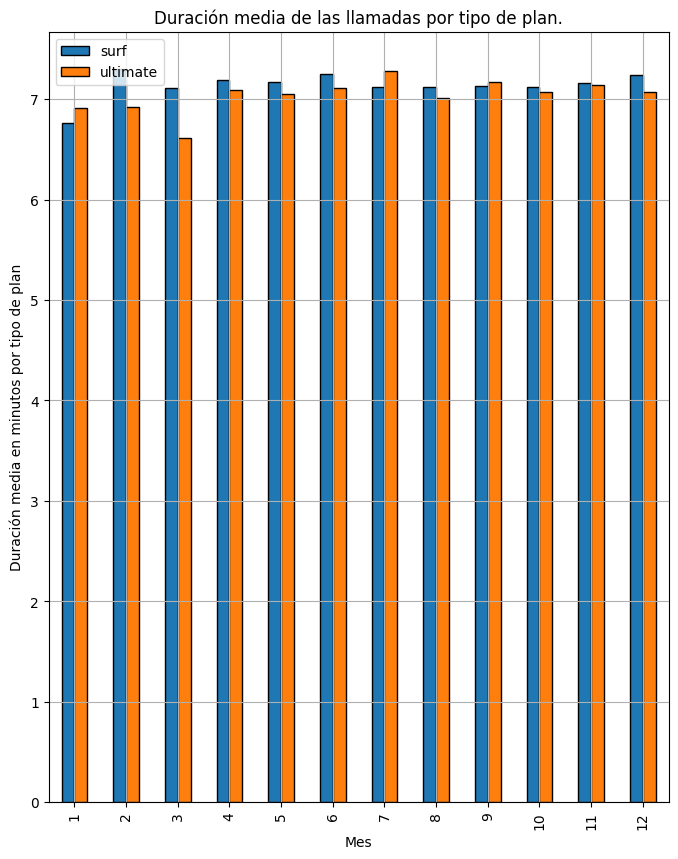

In [33]:
grouped_data.plot(title = 'Duración media de las llamadas por tipo de plan.',
                  xlabel = 'Mes', ylabel = 'Duración media en minutos por tipo de plan',
                  kind = 'bar', edgecolor = 'black', figsize = [8, 10], grid = True)

Se puede observar que la duración media de cada llamada por tipo de plan para cada mes es de aproximadamente 7 minutos, que tomando en cuenta que las desviaciones estándar son de aproximadamente 6 minutos, no se considera que haya mucha diferencia entre un tipo de plan y el otro.

Text(0.5, 0, 'Total de minutos usados mensualmente en llamadas por cada usuario')

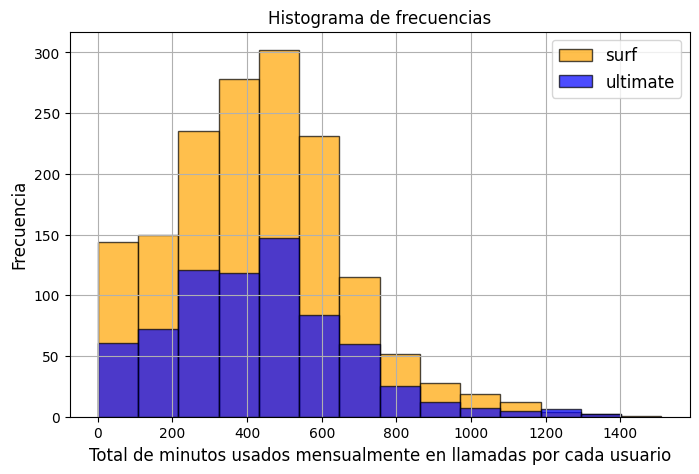

In [34]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

surf = df_summary[df_summary['plan'] == 'surf']
ultimate = df_summary[df_summary['plan'] == 'ultimate']

surf = surf['total_duration']
ultimate = ultimate['total_duration']
data = pd.concat([surf, ultimate], axis = 1)
data.columns = ['surf', 'ultimate']
data.plot(kind = 'hist',
          bins = 14,
          figsize = [8, 5],
          title = 'Histograma de frecuencias',
          color = ['orange', 'blue'],
          legend = ['surf', 'ultimate'],
          edgecolor = 'black',
          alpha = 0.7,
          grid = True)
plt.legend(fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)         
plt.xlabel('Total de minutos usados mensualmente en llamadas por cada usuario', fontsize=12)

- Se puede observar que el total me minutos usados en un mes por los clientes de cada plan tienen un distribución aproximada a una normal con una media cercana a los 500 minutos.

- Se puede observar que ambos tipos de plan presentan sesgo hacia la derecha.

- A los clientes del plan ultimate siempre le sobran minutos ya que la cantidad máxima de minutos totales usados en el mes es muy inferior a 3000 minutos.

- Muchos clientes del plan surf deben pagar minutos adicionales al plan cada mes, ya que cierto porcentaje de ellos usan más de 500 minutos mensualmente.

In [35]:
# Calcula la media y la varianza de la duración mensual de llamadas.

calls_surf = df_summary[df_summary['plan'] == 'surf']['total_duration'].dropna()
calls_ultimate = df_summary[df_summary['plan'] == 'ultimate']['total_duration'].dropna()

mean_duration_surf = calls_surf.mean()
var_duration_surf = calls_surf.var()
print('La media de la duración total de llamadas por mes del plan surf es:', mean_duration_surf,
      'minutos, y la varizanza es:', var_duration_surf, '.\n')

mean_duration_ultimate = calls_ultimate.mean()
var_duration_ultimate = calls_ultimate.var()
print('La media de la duración total de llamadas por mes del plan ultimate es:', mean_duration_ultimate,
      'mensajes, y la varizanza es:', var_duration_ultimate, '.')

print('\nPrueba de hipótisis para comprobar si hay diferencia entre las varianzas del total de llamadas mensual por tipo de plan.\n')

# HO: La variazas son iguales.
# HA: Las varianzas son distintas.
alpha = 0.05 # Se emplea un alpha de 5%.
result = levene(calls_surf, calls_ultimate)

if result.pvalue <= alpha:
    print('Se rechaza la hipótesis nula; por lo tanto, se concluye que las varianzas son distintas.')
else:
    print('Se acepta la hipótesis nula; por lo tanto, se concluye que las varianzas son iguales.')

print('El estadístico de prueba es:', result.statistic, 'y el p-valor es:', result.pvalue, '.')

print('\nPrueba de hipótesis para saber si hay diferencia entre la media de la duración total de llamadas al mes por tipo de plan.\n')

# HO: La media de duración total mensual de llamadas por tipo de plan son iguales.
# HA: Las media de la duración mensual de llamadas es distinta.
alpha = 0.05 # Se emplea un alpha de 5%.
result = st.ttest_ind(calls_surf, calls_ultimate, equal_var = True)

if result.pvalue <= alpha:
    print('Se rechaza la hipótesis nula; por lo tanto, se concluye que las medias de la duración mensual de llamadas son distintas.\n')
else:
    print('Se acepta la hipótesis nula; por lo tanto, se concluye que las medias de la duración mensual de llamadas son iguales.\n')

print('El estadístico de prueba es:', result.statistic, 'y el p-valor es:', result.pvalue, '.')

La media de la duración total de llamadas por mes del plan surf es: 428.7495232040687 minutos, y la varizanza es: 54968.279460650374 .

La media de la duración total de llamadas por mes del plan ultimate es: 430.45 mensajes, y la varizanza es: 57844.46481223922 .

Prueba de hipótisis para comprobar si hay diferencia entre las varianzas del total de llamadas mensual por tipo de plan.

Se acepta la hipótesis nula; por lo tanto, se concluye que las varianzas son iguales.
El estadístico de prueba es: 0.08017677249129099 y el p-valor es: 0.7770835792974985 .

Prueba de hipótesis para saber si hay diferencia entre la media de la duración total de llamadas al mes por tipo de plan.

Se acepta la hipótesis nula; por lo tanto, se concluye que las medias de la duración mensual de llamadas son iguales.

El estadístico de prueba es: -0.15988448918275708 y el p-valor es: 0.8729861616354788 .


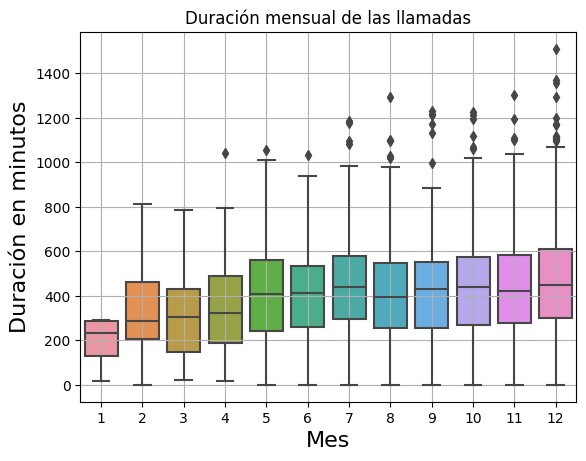

In [36]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

sns.boxplot(x='month', y='total_duration', data=df_summary)
plt.figsize = [15, 18]
plt.grid(True)
plt.title('Duración mensual de las llamadas')
plt.ylabel('Duración en minutos', fontsize=16)         
plt.xlabel('Mes', fontsize=16)

plt.show()

- Al calcular las medias y las desviaciones estándar, se puede observar que son muy similares el comportamiento de los clientes del plan surf a los del plan ultimate.

- Se observa que desde abril hasta diciembre hay algunos pocos clientes con un comportamiento atípico usando un mayor númeo de minutos que el resto de clintes.



### Mensajes

In [37]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
mean_messages_surf = df_summary[df_summary['plan'] == 'surf']['total_messages'].mean()
desv_messages_surf = np.sqrt(df_summary[df_summary['plan'] == 'surf']['total_messages'].var())
print('La media del total de mensajes enviados mensualmente del plan surf es',
     mean_messages_surf, 'mensajes, y la desviación estándar es:', desv_messages_surf, 'mensajes.\n')

mean_messages_ultimate = df_summary[df_summary['plan'] == 'ultimate']['total_messages'].mean()
desv_messages_ultimate = np.sqrt(df_summary[df_summary['plan'] == 'ultimate']['total_messages'].var())
print('La media del total de mensajes enviados mensualmente del plan ultimate es',
     mean_messages_ultimate, 'mensajes, y la desviación estándar es:', desv_messages_ultimate, 'mensajes.')

La media del total de mensajes enviados mensualmente del plan surf es 31.15956770502225 mensajes, y la desviación estándar es: 33.566717473569064 mensajes.

La media del total de mensajes enviados mensualmente del plan ultimate es 37.55138888888889 mensajes, y la desviación estándar es: 34.76717911404573 mensajes.


In [38]:
# Se hace una prueba de hipótesis para comprobar si exite diferencia entre las varianzas de la cantidad total de mensajes
#enviados por mes para cada tipo de plan:

# HO: Las varianzas de la cantidad total de mensajes enviados por mes son iguales para cada tipo de plan.
# HA: Las varianzas de la cantidad total de mensajes enviados por mes son distintas para cada tipo de plan.
alpha = .05 # Se escoge un alpha de 5%
result = levene(df_summary[df_summary['plan'] == 'surf']['total_messages'],
                df_summary[df_summary['plan'] == 'ultimate']['total_messages'])
if result.pvalue <= alpha:
    print('Las varianzas de la cantidad total de mensajes enviados por mes son distintas para cada tipo de plan.\n')
else:
    print('Las varianzas de la cantidad total de mensajes enviados por mes son iguales para cada tipo de plan.\n')

print('El estadístico de prueba es', result.statistic, 'y el p-valor es', result.pvalue)

Las varianzas de la cantidad total de mensajes enviados por mes son distintas para cada tipo de plan.

El estadístico de prueba es 8.603196894384647 y el p-valor es 0.0033890421146860585


In [39]:
#Se hace una prueba de hipótesis para comprobar diferencia entre las medias del total de mensajes mensuales por tipo de plan:

# HO: Las medias de la cantidad total de mensajes enviados por mes son iguales para cada tipo de plan.
# HA: Las medas de la cantidad total de mensajes enviados por mes son distintas para cada tipo de plan.
alpha = .05 # Se escoge un alpha de 5%
result = st.ttest_ind(df_summary[df_summary['plan'] == 'surf']['total_messages'],
                df_summary[df_summary['plan'] == 'ultimate']['total_messages'])
if result.pvalue <= alpha:
    print('Las medias de la cantidad total de mensajes enviados por mes son distintas para cada tipo de plan.\n')
else:
    print('Las medias de la cantidad total de mensajes enviados por mes son iguales para cada tipo de plan.\n')

print('El estadístico de prueba es', result.statistic, 'y el p-valor es', result.pvalue)

Las medias de la cantidad total de mensajes enviados por mes son distintas para cada tipo de plan.

El estadístico de prueba es -4.1844513800808105 y el p-valor es 2.9663595422753102e-05


Text(0.5, 0, 'Total de mensajes usados mensualmente por cada usuario')

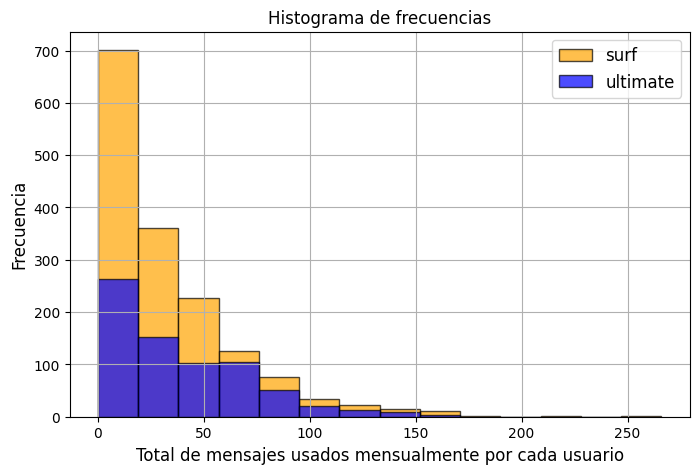

In [40]:
# Compara el número de mensajes mensuales que necesitan los usuarios de cada plan. Traza un histograma.

surf = df_summary[df_summary['plan'] == 'surf']
ultimate = df_summary[df_summary['plan'] == 'ultimate']

surf = surf['total_messages']
ultimate = ultimate['total_messages']
data = pd.concat([surf, ultimate], axis = 1)
data.columns = ['surf', 'ultimate']
data.plot(kind = 'hist',
          bins = 14,
          figsize = [8, 5],
          title = 'Histograma de frecuencias',
          color = ['orange', 'blue'],
          legend = ['surf', 'ultimate'],
          edgecolor = 'black',
          alpha = 0.7,
          grid = True)
plt.legend(fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)         
plt.xlabel('Total de mensajes usados mensualmente por cada usuario', fontsize=12)

- Se puede observar que la varianza en ambos tipos de plan para la cantidad de mensajes total del mes es igual.

- Observando el histograma de frecuencias, se puede apreciar que el comportamiento de los clientes de cada tipo de plan en cuento a la cantidad de mensajes que usan mensualmente, es igual.

- La cantidad de mensajes enviados mensualmente tiene un comportamiento exponencial; esto es, son más frecuentes los usuarios que envían pocos mensajes y poco frecuentes los que envía muchos mensajes.

### Internet

In [57]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
mean_gb_surf = df_summary[df_summary['plan'] == 'surf']['gb_used'].mean()
desv_gb_surf = np.sqrt(df_summary[df_summary['plan'] == 'surf']['gb_used'].var())
mean_gb_ultimate = df_summary[df_summary['plan'] == 'ultimate']['gb_used'].mean()
desv_gb_ultimate = np.sqrt(df_summary[df_summary['plan'] == 'ultimate']['gb_used'].var())

print('Para el plan surf:')
print(f'La media de consumo de datos mensual es de {mean_gb_surf:.3f} GB')
print(f'y la desvaición estándar es de  {desv_gb_surf:.3f} GB\n')
print('\nPara el plan ultimate:')
print(f'La media de consumo de datos mensual es de {mean_gb_ultimate:.3f} GB')
print(f'y la desviación estándar es de {desv_gb_ultimate:.3f} GB')

Para el plan surf:
La media de consumo de datos mensual es de 16.671 GB
y la desvaición estándar es de  7.848 GB


Para el plan ultimate:
La media de consumo de datos mensual es de 17.307 GB
y la desviación estándar es de 7.670 GB


In [64]:
# Se calcula el ingreso promedio por datos para cada tipo de plan:
print('El ingreso promedio mensual por datos para cliente del plan surf es',
     df_summary[df_summary['plan'] == 'surf']['price_internet'].mean(), 'dólares.\n')
print('El ingreso promedio mensual por datos para cliente del plan ultimate es',
     df_summary[df_summary['plan'] == 'ultimate']['price_internet'].mean(),'dólares.')

El ingreso promedio mensual por datos para cliente del plan surf es 38.65225683407502 dólares.

El ingreso promedio mensual por datos para cliente del plan ultimate es 2.313888888888889 dólares.


In [61]:
# Se hace una prueba levene para verificar si las varianzas de cantidad total de datos usados en el mes por tipo de plan son
# iguales:

# Se plantean las hiótesis:
# HO: Las varianzas de la cantidad total de datos usados por mes para cada tipo de plan son iguales.
# HA: Las varianzas de la cantidad total de datos usados por mes para cada tipo de plan son distintas.
alpha = .05 # Se escoge un alpha del 5%
result = levene(df_summary[df_summary['plan'] == 'surf']['gb_used'],
               df_summary[df_summary['plan'] == 'ultimate']['gb_used'])
if result.pvalue <= alpha:
    print('Las varianzas de la cantidad total de datos usados por mes para cada tipo de plan son distintas.\n')
else:
    print('Las varianzas de la cantidad total de datos usados por mes para cada tipo de plan son iguales.\n')
print(f'El estadístico de prueba es {result.statistic:.4f} y el p-value es {result.pvalue:.4f}.')

Las varianzas de la cantidad total de datos usados por mes para cada tipo de plan son iguales.

El estadístico de prueba es 0.3822 y el p-value es 0.5365.


In [62]:
# Se hace el ttest_ind para verificar si la media de la cantidad total de datos usadas ern el mes es igual para cada tipo de plan:

# Se plantean las hipótesis:
# HO: Las medias de la cantidad total de datos usados en el mes para cada tipo de plan son iguales.
# HA: Las medias de la cantidad total de datos usados en el mes para cada tipo de plan son distintas.
alpha = .05 # Se escoge un alpha de 5%.
result = st.ttest_ind(df_summary[df_summary['plan'] == 'surf']['gb_used'],
               df_summary[df_summary['plan'] == 'ultimate']['gb_used'], equal_var = True)
if result.pvalue <= alpha:
    print(f'Las medias de la cantidad total de datos usados en el mes para cada tipo de plan son distintas.\n')
else:
    print('Las medias de la cantidad total de datos usados en el mes para cada tipo de plan son iguales.\n')
print(f'El estadístico de prueba es {result.statistic:.4f} y el p-value es {result.pvalue:.4f}.')

Las medias de la cantidad total de datos usados en el mes para cada tipo de plan son iguales.

El estadístico de prueba es -1.8147 y el p-value es 0.0697.


Text(0.5, 0, 'Total de datos usados mensualmente por cada usuario (GB)')

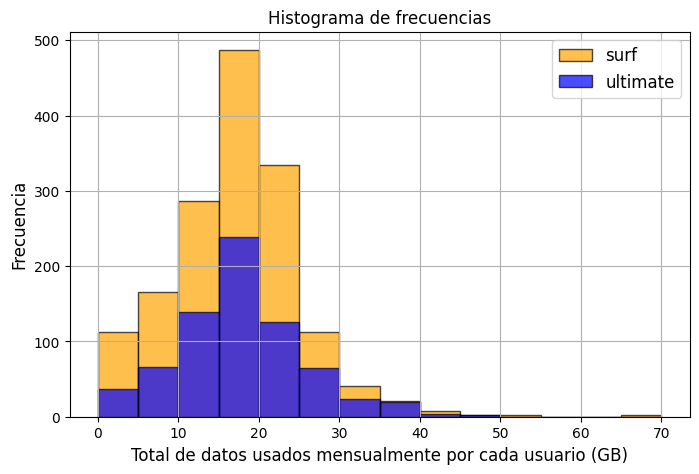

In [45]:
# Compara el número de datos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

surf = df_summary[df_summary['plan'] == 'surf']
ultimate = df_summary[df_summary['plan'] == 'ultimate']

surf = surf['gb_used']
ultimate = ultimate['gb_used']
data = pd.concat([surf, ultimate], axis = 1)
data.columns = ['surf', 'ultimate']
data.plot(kind = 'hist',
          bins = 14,
          figsize = [8, 5],
          title = 'Histograma de frecuencias',
          color = ['orange', 'blue'],
          legend = ['surf', 'ultimate'],
          edgecolor = 'black',
          alpha = 0.7,
          grid = True)
plt.legend(fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)         
plt.xlabel('Total de datos usados mensualmente por cada usuario (GB)', fontsize=12)

- El ingreso por concepto de datos extras pagados por tipo de plan es mayor en el plan surf que en el plan ultimate.

- La cantidad media del total de datos usados por cliente mensualmente para cada tipo de plan son iguales.

- Las varianzas de la cantidad total de datos usados mensualmente son iguales para los dos tipos de plan.

- La cantidad total de datos usados mensualmente tiene una media de 17 GB aproximadamente, y esto es cierto para ambos tipos de plan.

- Se observa que el uso de datos usados mesualmente por tipo de plan tiene una distribución normal en torno a la media ya mencionada y que esta gráfica presenta sesgo hacia la derecha, siendo menos frecuentes los clientes que usan mayor y menor cantidad de datos que la media y más fecuentes los que usan una cantidad de datos más cercanos a la media.

## Ingreso

In [55]:
# Se calcula la media y la desviación estandar para los ingresos del plan surf:
print('El ingreso promedio mensual por cliente del plan surf es:',
      df_summary[df_summary['plan'] == 'surf']['total_price'].mean(),
      'dólares, y la desviación estándar es:',
      np.sqrt(df_summary[df_summary['plan'] == 'surf']['total_price'].var()), '.')


El ingreso promedio mensual por cliente del plan surf es: 60.70640813731723 dólares, y la desviación estándar es: 55.388041600095214 .


In [53]:
# Se calcula la media y la desviación estandar para los ingresos del plan ultimate:

print('El ingreso promedio mensual por cliente del plan ultimate es:',
      df_summary[df_summary['plan'] == 'ultimate']['total_price'].mean(),
      'dólares, y la desviación estandar es:',
      np.sqrt(df_summary[df_summary['plan'] == 'ultimate']['total_price'].var()), 'dólares.')



El ingreso promedio mensual por cliente del plan ultimate es: 72.31388888888888 dólares, y la desviación estandar es: 11.395107965742119 dólares.


Se puede observar que el costo promedio mensual por tipo de plan es ligeramente mayor en el plan ultimate que en el plan surf, pero la desviación estándar es mayor para el plan surf.

## Prueba las hipótesis estadísticas

In [67]:
# Prueba las hipótesis



# Se plantean las hipótesis:
# HO: Las varianzas del ingreso mensual por plan son iguales.
# HA: Las varianzas del ingreso mensual por plan son distintas.

income_surf = df_summary[df_summary['plan'] == 'surf']['total_price'].dropna()
income_ultimate = df_summary[df_summary['plan'] == 'ultimate']['total_price'].dropna()


# HO: La variazas son iguales.
# HA: Las varianzas son distintas.
alpha = .05 # Se emplea un alpha de 5%.
result = levene(income_surf, income_ultimate)

if result.pvalue <= alpha:
    print('Se rechaza la hipótesis nula, por lo tanto, se concluye que las varianzas son distintas.')
else:
    print('Se acepta la hipótesis nula, por lo tanto, se concluye que las varianzas son iguales. \n')

print(f'\nEl estadístico de prueba es {result.statistic:.3f} y el p-valor es {result.pvalue}.')


Se rechaza la hipótesis nula, por lo tanto, se concluye que las varianzas son distintas.

El estadístico de prueba es 404.730 y el p-valor es 5.028876110654919e-83.


In [68]:
# Se prueba si el ingreso mensual por tipo de plan es distinto:


# Se plantean las hipótesis:
# HO: El ingreso promedio por tipo de plan es igual.
# HA: el ingreso promedio por tipo de plan es distinto.
aplha = .05 # Se escoge un alpha de 5%
result = st.ttest_ind(income_ultimate, income_surf, equal_var = False)
if result.pvalue <= alpha:
    print('Se rechaza la hipótesis nula; es decir, los ingresos promedio por tipo de plan son distintos.')
else:
    print('Se acepta la hipótesis nula; es decir, los ingresos promedio por tipo de plan son iguales.')

print(f'\nEl estadístico de prueba es {result.statistic:.3f} y el p-valor es {result.pvalue}.')

Se rechaza la hipótesis nula; es decir, los ingresos promedio por tipo de plan son distintos.

El estadístico de prueba es 7.952 y el p-valor es 3.1703905481137102e-15.


- Se puede concluir que el promedio de ingresos es menor para el tipo de plan surf que para el plan ultimate.

- La desviación estándar es mayor para el tipo de plan surf.

- Las pruebas estadísticas revelan que si existe diferencia entre los ingresos por tipo de plan.

In [70]:
# Prueba las hipótesis

income_ny = df_summary[df_summary['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_price']
income_others = df_summary[df_summary['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_price']

# Se prueba si las varianzas son distintas:
# HO: La hipótesis nula es que las varianzas son iguales.
# HA: La hipótesis alternativa es que las varianzas son distintas.
print('Prueba de hipótesis para verificar si las varianzas son iguales: \n')
result = levene(income_ny, income_others)
alpha = .05
if result.pvalue <= alpha:
    print('Se rezacha la hipótesis nula; es decir, la evidencia estadística indica que las varianzas son distintas.')
else:
    print('Se acepta la hipótesis nula; es decir, la evidencia estadística indica que las varianzas son iguales.')

print(f'\nEl estadístico de prueba es {result.statistic:.3f} y el p-valor es {result.pvalue}.')

Prueba de hipótesis para verificar si las varianzas son iguales: 

Se acepta la hipótesis nula; es decir, la evidencia estadística indica que las varianzas son iguales.

El estadístico de prueba es 2.345 y el p-valor es 0.12580091109612837.


In [52]:
print('\nPrueba de hipótesis de que el ingreso promedio de NY-NJ es igual al de otras regiones: \n')
# Se prueba si existe diferencia entre el promedio de ingresos del área de NY-NJ con respecto a las otras regiones.
# HO: La hipótesis nula es que los ingresos promedio de la región NY-NJ es igual al de las otras regiones.
# HA: La hipótesis alternativa es que el ingreso promedio de la región NY-NJ es distinto al de las otras regiones.
result_ny = st.ttest_ind(income_ny, income_others, equal_var = True)
if result_ny.pvalue <= alpha:
    print('Se rechaza la hipótesis nula; es decir, el análisis estadístico indica que el promedio de ingreso de la región de NY-NJ es distinto al de las otras regiones.')
else:
    print('Se acepta la hipótesis nula; es decir, el análisis estadístico indica que el promedio de ingreso de la región de NY-NJ es igual al de las otras regiones.')

print('\nEl estadístico de prueba es:', result_ny.statistic, 'y el p-valor es:', result_ny.pvalue)


Prueba de hipótesis de que el ingreso promedio de NY-NJ es igual al de otras regiones: 

Se rechaza la hipótesis nula; es decir, el análisis estadístico indica que el promedio de ingreso de la región de NY-NJ es distinto al de las otras regiones.

El estadístico de prueba es: -2.019442981896802 y el p-valor es: 0.04355743162134332


## Conclusión general

[En esta sección final, enumera tus conclusiones importantes. Asegúrate de que estas abarquen todas las decisiones (suposiciones) importantes que adoptaste y que determinaron la forma elegida para procesar y analizar los datos.]

- En cuanto al uso de llamadas, mensajes e internet, se puede concluir que los clientes de cada tipo de plan tiene un comprtamiento similar.

- Al estudiar los ingresos promedio por el consumo de datos extras se puede observar que ese valor es mas alto para el plan surf que para el ultimate.

- Al hacer la prueba estadística se puede observar que si hay diferencias en el promedio de ingresos mesnusales por tipo de plan.

- El ingreso total promedio es mayor para el plan ultimate que para el plan surf, con una diferencia promedio de USD 12 aproximadamente, esto es, un 20% más de ingreso de los clientes con el plan ultimate, respecto al plan surf.

- Tomando en consideración que el plan ultimate representa mayores ingresos promedio para la empresa, la recomendación que se hace a la empresa de telecomunicaciones es que haga publicidad al plan ultimate promoviendo que los clientes del plan surf cambien al plan ultimate.

- Del mismo modo, se plantea dirigir publicidad a los que no son clientes actuales de la empresa a que se hagan clientes del plan ultimate.